# Monte Carlo Pricing

In [129]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, lognorm
from tqdm import tqdm_notebook as tqdm

sns.set_style('white')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Define Pricing Functions

In [139]:
#%%writefile report/scripts/sampleendprice.py
import numpy as np
import pandas as pd

def sample_end_price(S0, local_vol_f, duration, n_intervals, n_samples):
    """
    Draw samples from the end price of an asset diffusion.
    
    Inputs
    ------
    S0 : float
        The initial spot price of the underlying at time t=0
        
    local_vol_f : float -> float (vectorized)
        The local volatility at a given spot price (assumed constant over time)
        
    duration : float
        The time to expiry, i.e. T.
    
    n_intervals : float
        Number of intervals into which to break up the numerical simulation
    
    n_samples : int
        Number of simulations to run
        
    Output
    -----
    S : NumPy float vector of length n_samples
        The ending spot prices of the asset diffusion for each simulation
    """
    if duration == 0:
        return S0 * np.ones(n_samples)
    
    
    dt = duration / n_intervals
    scaling_factor =  np.sqrt(duration / n_intervals)
    S = S0 * np.ones(n_samples)
    for i in range(1,n_intervals+1):
        time = i / duration
        local_vols = local_vol_f(S, time)
        growth_factor = np.exp(local_vols * np.random.randn(n_samples) * scaling_factor
                              - dt * local_vols**2/2)
        S = S * growth_factor
    return S

def sample_end_prices(S0, local_vol_f, durations, intervals_per_year, n_samples):
    S = np.zeros((n_samples, len(durations)))
    for i,duration in enumerate(durations):
        n_intervals = max(1,int(duration * intervals_per_year))
        S[:,i] = sample_end_price(S0, local_vol_f, duration, n_intervals, n_samples)
    df = pd.DataFrame(S, columns=durations)
    df.columns.name = 'Expiries'
    return df

In [131]:
#%%writefile report/scripts/pricecall.py
import numpy as np
import pandas as pd

def price_call(K, end_samples):
    """
    Price a call option using Monte Carlo samples.
    
    Inputs
    ------
    K : float:
        The strike price of the call option we are pricing.
    
    end_samples : np.array[float]
        A NumPy array of draws from the distribution of prices
        of the underlying at expiry.
        
    Outputs
    -------
    px : float
        A point estimate for the price of the call option
    sd : float
        An estimate of the standard error incurred from this pricing.
    """
    
    payoffs = np.clip(np.subtract.outer(end_samples, K), 0, np.inf)
    px = payoffs.mean(axis=0)
    sd = payoffs.std(axis=0) / np.sqrt(len(end_samples))
    return px, sd

def price_calls(Ks, samples):
    payoffs = np.clip(np.subtract.outer(samples, Ks), 0, np.inf)
    px = payoffs.mean(axis=0)
    df = pd.DataFrame(px, index=samples.columns, columns=Ks)
    df.index.name = 'Expiry'
    df.columns.name = 'Strikes'
    return df

In [132]:
#%%writefile report/scripts/blackscholesprice.py
import numpy as np
from scipy.stats import norm

def black_scholes_price(S, vol, T, K):
    """
    A Black Scholes pricer for European call options which assumes 
    interest rates are 0 and an underlying that doesn't pay out dividends.
    
    Inputs
    ------
    S : float
        The initial price of the underlying
    vol : float
        The annualized volatility of the underlying
    T : float
        The time to expiry (in years)
    K : float
        The strike price of the call option
        
    Outputs
    -------
    px : float
        The price of the call option under the Black Scholes model with 0
        risk-free interest rate.
    """
    d1 = (np.log(S / K) + (vol**2/2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    return S * norm.cdf(d1) - K*norm.cdf(d2)

## Test this in Black-Scholes World

From our Monte Carlo pricer, we get a sense of the uncertainty through the theoretical standard error. However, we'd love to get the chance to empirically assess this error. Calculating the error requires knowing the exact answer we're looking for. Since we know that Black-Scholes is a special case of local volatility that we have closed-form solutions for, we can take advantage of this to assess our pricer.

In [133]:
# Black Scholes requires constant local vol

def make_constant_vol_f(vol):
    def f(price, time):
        return vol
    return f

vol16 = make_constant_vol_f(.16)

In [147]:
%time samples = sample_end_price(100, vol16, np.array([2,]), 1, int(1e5))

CPU times: user 6.69 ms, sys: 970 µs, total: 7.66 ms
Wall time: 6.32 ms


In [141]:
samples = sample_end_prices(100, vol16, [1, 2], 2, int(1e5))

In [148]:
samples.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [149]:
K = [80, 100, 120]

In [150]:
price_calls(K, samples)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

The Black Scholes model predicts that the risk-neutral distribution of the underlying at expiry will be given by,
$$S_T \sim \log \mathcal{N}\left( \ln S + \left( -\frac{\sigma^2}{2} \right) T, \sigma \sqrt{T}\right)$$
where we assume that the risk-free rate (drift) is 0. We can compare this theoretical distribution to the empirical one we're sampling from.

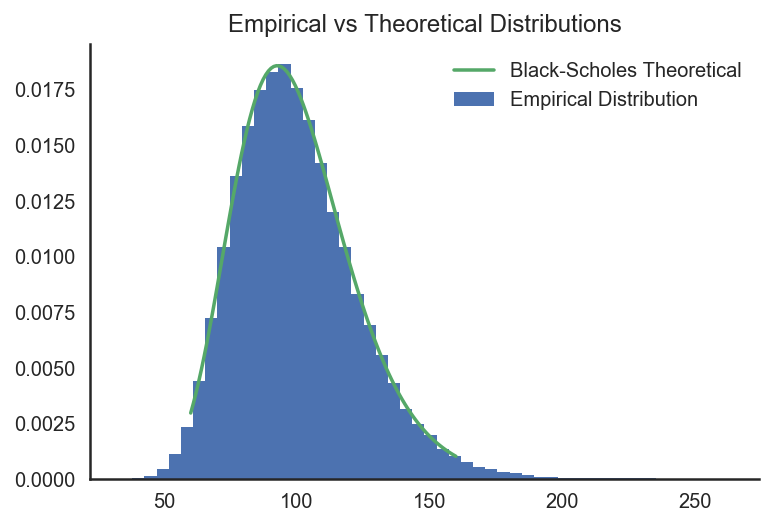

In [151]:
x = np.linspace(60, 160, 100)

vol = .16
n_years = 2
Vol = .16*np.sqrt(n_years)

plt.hist(samples, bins=50, normed=True, label='Empirical Distribution');
plt.plot(x, lognorm.pdf(x, Vol, 0, 100*np.exp(-Vol**2/2)), label='Black-Scholes Theoretical')
sns.despine()
plt.legend()
plt.title('Empirical vs Theoretical Distributions')

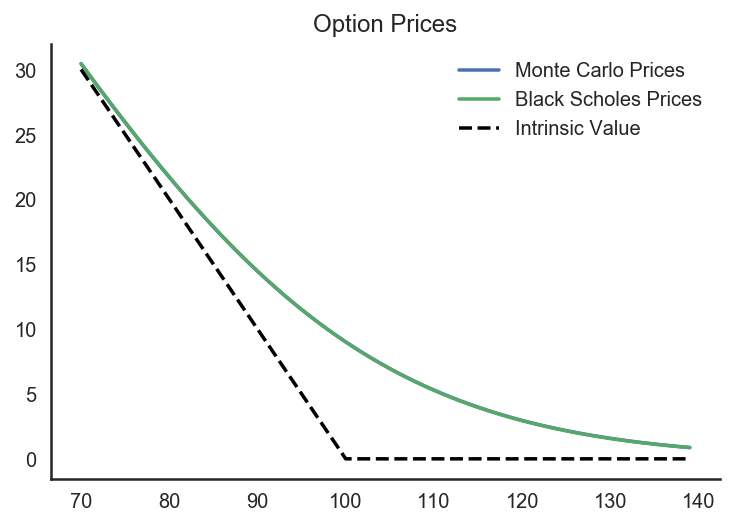

In [153]:
plt.figure()
strikes = np.arange(70,140,1)
pxs, sds = price_call(strikes, samples)
bs_px = black_scholes_price(100, .16, 2, strikes)

plt.plot(strikes, pxs, label='Monte Carlo Prices')
plt.plot(strikes, bs_px, label='Black Scholes Prices')
plt.plot(strikes, np.clip(100-strikes, 0, np.inf), '--', c='k', label='Intrinsic Value')
plt.title('Option Prices')
sns.despine()
plt.legend();

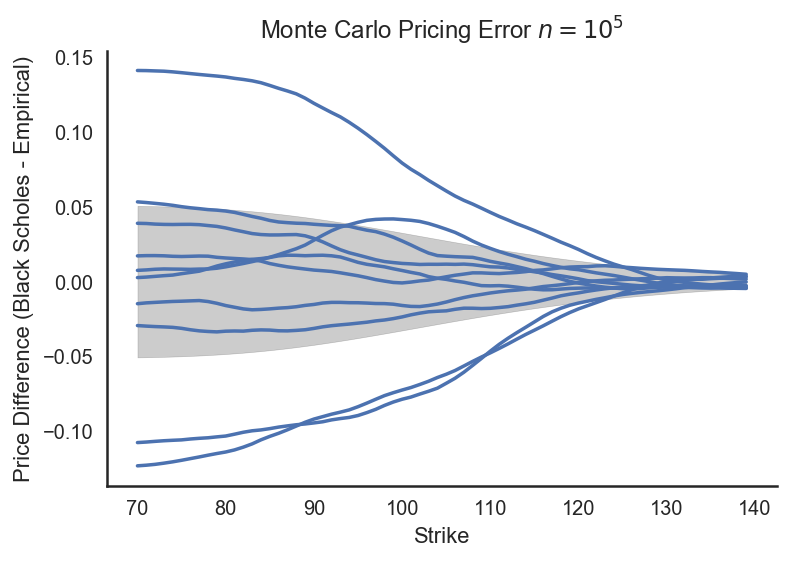

In [23]:
for i in range(10):
    samples = sample_end_price(100, vol16, 1, 1, int(1e5))
    pxs, sds = price_call(strikes, samples)
    plt.plot(strikes, bs_px-pxs, label='Realized Error', c='C0')
plt.fill_between(strikes, -sds, sds, alpha=.2, color='k', label='Standard Error')
plt.title('Monte Carlo Pricing Error $n=10^5$')
sns.despine()
plt.xlabel('Strike')
plt.ylabel('Price Difference (Black Scholes - Empirical)');

## Explore Discretization Error

By the assumptions of the Black-Scholes model, it is mathematically the same whether we break up the time interval into one or very many discrete sub-intervals. However, this is not in general the case, and we can explore the effects of discretization error when we consider a toy quadratic local volatility function.

In [24]:
def quadratic_vol(px, time):
    return np.clip(.16 + 1e-4*(px-100)**2, 0, .3)

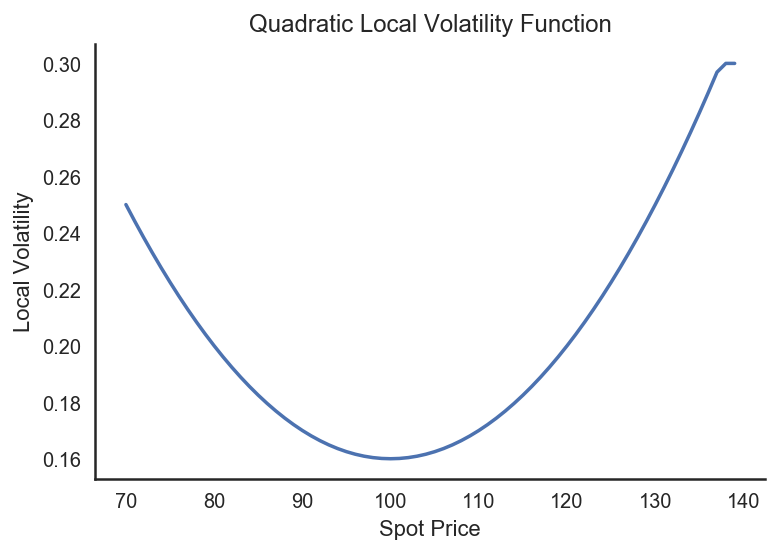

In [25]:
plt.plot(strikes, quadratic_vol(strikes, 1))
plt.title('Quadratic Local Volatility Function')
plt.xlabel('Spot Price')
plt.ylabel('Local Volatility')
sns.despine();

In [26]:
%time quad_samples = sample_end_price(100, quadratic_vol, 1, 10, int(1e5))
pxs, sds = price_call(strikes, quad_samples)

CPU times: user 53.9 ms, sys: 4.28 ms, total: 58.1 ms
Wall time: 59.1 ms


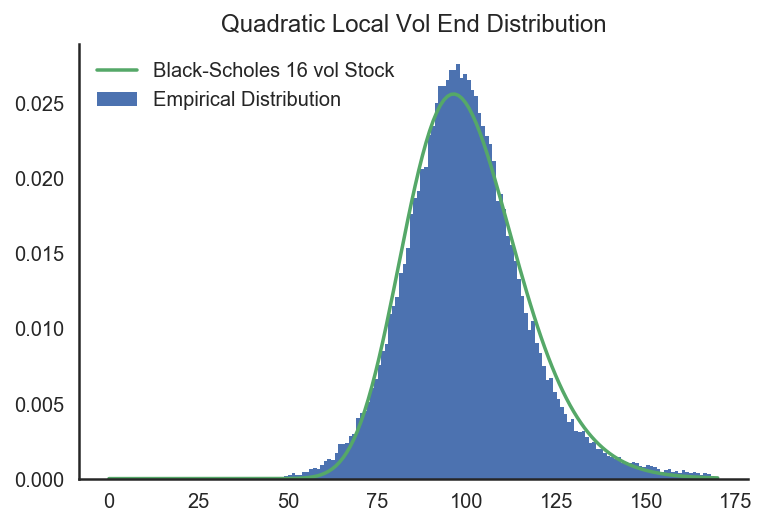

In [27]:
x = np.linspace(0, 170, 170)

plt.hist(quad_samples, bins=range(170), normed=True,
        label='Empirical Distribution')
plt.plot(x, lognorm.pdf(x, .16, 0, 100*np.exp(-.16**2/2)), 
         label='Black-Scholes 16 vol Stock')
plt.legend()
plt.title('Quadratic Local Vol End Distribution')
sns.despine()

In [28]:
px_vec = []
sd_vec = []
ns = [1, 2, 3, 4, 5, 10, 25]

for n in tqdm(ns):
    quad_samples = sample_end_price(100, quadratic_vol, 1, n, int(1e6))
    px, sds = price_call(strikes, quad_samples)
    px_vec.append(px)
    sd_vec.append(sds)

quad_samples = sample_end_price(100, quadratic_vol, 1, 100, int(1e6))
px_best, _ = price_call(strikes, quad_samples)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

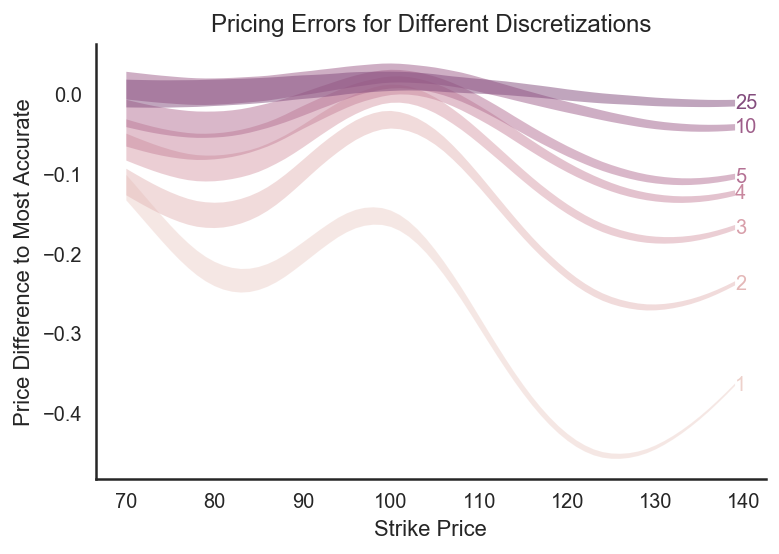

In [29]:
with sns.cubehelix_palette(10):
    for i in range(len(ns)):
        plt.fill_between(strikes, px_vec[i]-px_best-sd_vec[i], 
                         px_vec[i]-px_best+sd_vec[i],
                         label='%i Interval%s' % (ns[i], 's' if ns[i]!=1 else ''),
                         alpha=.5) 
#         plt.plot(strikes, px_vec[i]-px_best)
        if i < 30:
            plt.text(strikes[-1], px_vec[i][-1]-px_best[-1], str(ns[i]),
                    color=sns.color_palette()[i], verticalalignment='center')
        else:
            plt.text(strikes[0], px_vec[i][0]-px_best[0], str(ns[i]),
                    color=sns.color_palette()[i], horizontalalignment='right',
                    verticalalignment='center')
plt.title('Pricing Errors for Different Discretizations')
plt.xlabel('Strike Price')
plt.ylabel('Price Difference to Most Accurate')
# plt.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine()

In [30]:
px_vec = []
sd_vec = []
ns = list(range(1,11))

for n in tqdm(ns):
    quad_samples = sample_end_price(100, quadratic_vol, 1, n, int(1e6))
    px, sds = price_call(strikes, quad_samples)
    px_vec.append(px)
    sd_vec.append(sds)

quad_samples = sample_end_price(100, quadratic_vol, 1, 100, int(1e6))
px_best, _ = price_call(strikes, quad_samples)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

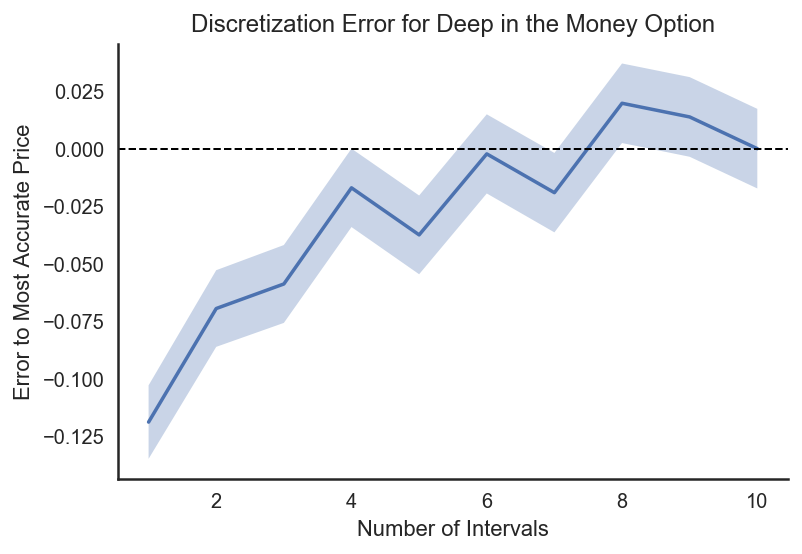

In [31]:
errs = np.array([v[0] for v in px_vec])
errs = errs - px_vec[-1][0]
err_bar = np.array([v[0] for v in sd_vec])

plt.plot(ns, errs)
plt.fill_between(ns, errs-err_bar, errs+err_bar, alpha=.3)
plt.axhline(0, ls='dashed', c='k', linewidth=1)
plt.title('Discretization Error for Deep in the Money Option')
plt.xlabel('Number of Intervals')
plt.ylabel('Error to Most Accurate Price')
sns.despine()

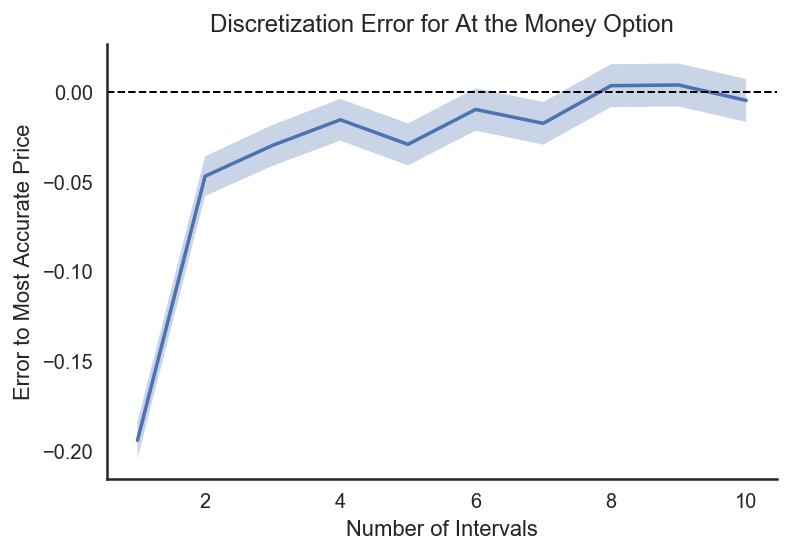

In [32]:
atm_i = (strikes>=100).argmax()

errs = np.array([v[atm_i] for v in px_vec])
errs = errs - px_best[atm_i]
err_bar = np.array([v[atm_i] for v in sd_vec])

plt.plot(ns, errs)
plt.fill_between(ns, errs-err_bar, errs+err_bar, alpha=.3)
plt.axhline(0, ls='dashed', c='k', linewidth=1)
plt.title('Discretization Error for At the Money Option')
plt.xlabel('Number of Intervals')
plt.ylabel('Error to Most Accurate Price')
sns.despine()

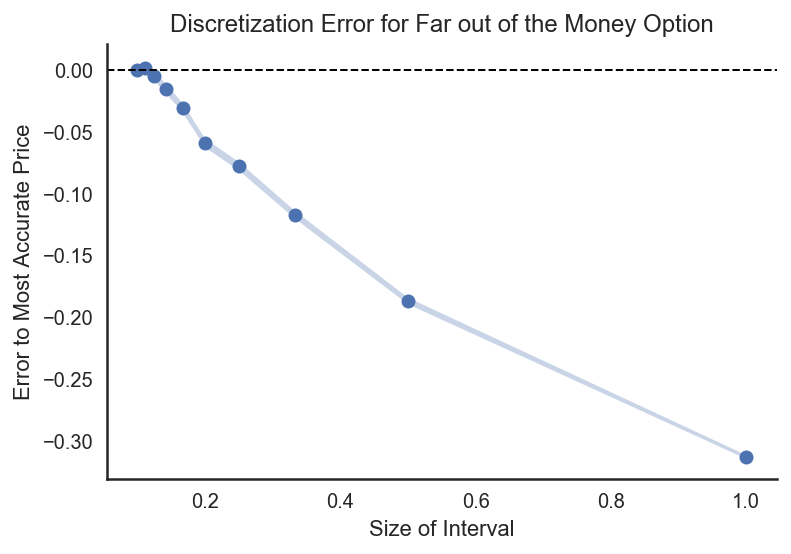

In [36]:
errs = np.array([v[-1] for v in px_vec])
errs = errs - px_vec[-1][-1]
err_bar = np.array([v[-1] for v in sd_vec])

plt.plot(1/np.array(ns), errs, 'o')
plt.fill_between(1/np.array(ns), errs-err_bar, errs+err_bar, alpha=.3)
plt.axhline(0, ls='dashed', c='k', linewidth=1)
plt.title('Discretization Error for Far out of the Money Option')
plt.xlabel('Size of Interval')
plt.ylabel('Error to Most Accurate Price')
sns.despine()

In [42]:
df = pd.DataFrame({'n': ns, 'err': np.abs(errs)})

In [45]:
df

,err,n
0,0.313482,1
1,0.187114,2
2,0.117515,3
3,0.077973,4
4,0.059187,5
5,0.030423,6
6,0.015763,7
7,0.004874,8
8,0.001339,9
9,0.000000,10


In [37]:
import statsmodels.formula.api as smf

In [49]:
print(smf.ols('np.log(err) ~ np.log(n)', data=df.head(9)).fit().summary2())

                Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.737  
Dependent Variable: np.log(err)      AIC:                25.5917
Date:               2017-12-12 16:09 BIC:                25.9861
No. Observations:   9                Log-Likelihood:     -10.796
Df Model:           1                F-statistic:        23.38  
Df Residuals:       7                Prob (F-statistic): 0.00189
R-squared:          0.770            Scale:              0.82904
-----------------------------------------------------------------
              Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-----------------------------------------------------------------
Intercept    -0.2480    0.7053  -0.3516  0.7355  -1.9157   1.4197
np.log(n)    -2.1643    0.4476  -4.8356  0.0019  -3.2226  -1.1059
----------------------------------------------------------------
Omnibus:              1.816        Durbin-Watson:          0.562
Prob(Omnibus):        0.403        Ja

/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


## Distribution Differences

In [ ]:
sample2 = sample_end_price(100, quadratic_vol, 1, 2, int(1e6))
sample10 = sample_end_price(100, quadratic_vol, 1, 10, int(1e6))
sample10again = sample_end_price(100, quadratic_vol, 1, 10, int(1e6))
sample100 = sample_end_price(100, quadratic_vol, 1, 10, int(1e6))

In [ ]:
bins = range(50,201)
bins2, _ = np.histogram(sample2, bins)
bins10, _ = np.histogram(sample10, bins)
bins10again, _ = np.histogram(sample10again, bins)
bins100, _ = np.histogram(sample100, bins)

In [ ]:
plt.bar(bins[1:], bins10-bins100)
sns.despine()

In [ ]:
plt.bar(bins[1:], bins10-bins10again)
sns.despine()

In [ ]:
plt.bar(bins[1:], bins2-bins100)
sns.despine()